In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
# import seaborn as sns
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

In [2]:
root_dir = pathlib.Path(os.getcwd()).parent
data_dir = root_dir / "data"

# Data Loading

In [3]:
data = pd.read_csv(data_dir / "epa_tw_18.csv")
data.head()

,Unnamed: 0,SiteEngName,sn,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,...,WIND_DIREC,WIND_SPEED,WIND_cos,WIND_sin,WS_HR,W_HR_cos,W_HR_sin,lat,lon,read_time
0,1,Annan,安南,16.5,2.1,0.61,0.12,1.2,17.0,18.0,...,354.0,1.9,1.889592,-0.198604,1.9,1.895372e+00,-0.132537,"(23.04, 23.05)","(120.21, 120.22)",2018/1/1 00:00:00
1,2,Banqiao,板橋,16.1,1.9,0.37,0.07,0.9,9.8,11.0,...,81.0,1.7,0.265939,1.679070,1.4,8.570000e-17,1.400000,"(25.01, 25.02)","(121.45, 121.46)",2018/1/1 00:00:00
2,3,Cailiao,菜寮,15.8,0.0,0.35,0.00,0.4,10.0,10.0,...,91.0,2.3,-0.040141,2.299650,2.7,-1.413071e-01,2.696300,"(25.06, 25.07)","(121.48, 121.49)",2018/1/1 00:00:00
3,4,Changhua,彰化,16.0,1.9,0.40,0.11,0.9,9.8,11.0,...,5.2,4.2,4.182714,0.380657,3.9,3.893919e+00,0.217704,"(24.06, 24.07)","(120.54, 120.55)",2018/1/1 00:00:00
4,5,Chaozhou,潮州,18.0,0.0,0.93,0.00,1.2,17.0,18.0,...,49.0,1.1,0.721665,0.830181,0.8,6.709365e-01,0.435711,"(22.52, 22.53)","(120.56, 120.57)",2018/1/1 00:00:00


In [5]:
data.columns

Index(['Unnamed: 0', 'SiteEngName', 'sn', 'AMB_TEMP', 'CH4', 'CO', 'NMHC',
       'NO', 'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL',
       'RAIN_COND', 'RH', 'SO2', 'THC', 'UVB', 'WD_HR', 'WIND_DIREC',
       'WIND_SPEED', 'WIND_cos', 'WIND_sin', 'WS_HR', 'W_HR_cos', 'W_HR_sin',
       'lat', 'lon', 'read_time'],
      dtype='object')

In [17]:
pm25 = data[[
    "SiteEngName",
    "PM2.5",
    "lon",
    "lat",
    "read_time"
    ]]
pm25.head()

,SiteEngName,PM2.5,lon,lat,read_time
0,Annan,42.0,"(120.21, 120.22)","(23.04, 23.05)",2018/1/1 00:00:00
1,Banqiao,20.0,"(121.45, 121.46)","(25.01, 25.02)",2018/1/1 00:00:00
2,Cailiao,16.0,"(121.48, 121.49)","(25.06, 25.07)",2018/1/1 00:00:00
3,Changhua,55.0,"(120.54, 120.55)","(24.06, 24.07)",2018/1/1 00:00:00
4,Chaozhou,115.0,"(120.56, 120.57)","(22.52, 22.53)",2018/1/1 00:00:00


In [19]:
pm25_cailiao = pm25[pm25['SiteEngName'] == "Cailiao"]

# simplify the column names
# remove non alpha numeric, convert all to lowercase
col_name_mapping = {_: ''.join(filter(str.isalnum, _)).lower() for _ in pm25_cailiao.columns}
pm25_cailiao = pm25_cailiao.rename(columns=col_name_mapping)

# convert column data type
pm25_cailiao['readtime'] = pd.to_datetime(pm25_cailiao['readtime'])

In [20]:
pm25_cailiao.head()

,siteengname,pm25,lon,lat,readtime
2,Cailiao,16.0,"(121.48, 121.49)","(25.06, 25.07)",2018-01-01 00:00:00
78,Cailiao,19.0,"(121.48, 121.49)","(25.06, 25.07)",2018-01-01 01:00:00
154,Cailiao,19.0,"(121.48, 121.49)","(25.06, 25.07)",2018-01-01 02:00:00
230,Cailiao,17.0,"(121.48, 121.49)","(25.06, 25.07)",2018-01-01 03:00:00
306,Cailiao,15.0,"(121.48, 121.49)","(25.06, 25.07)",2018-01-01 04:00:00


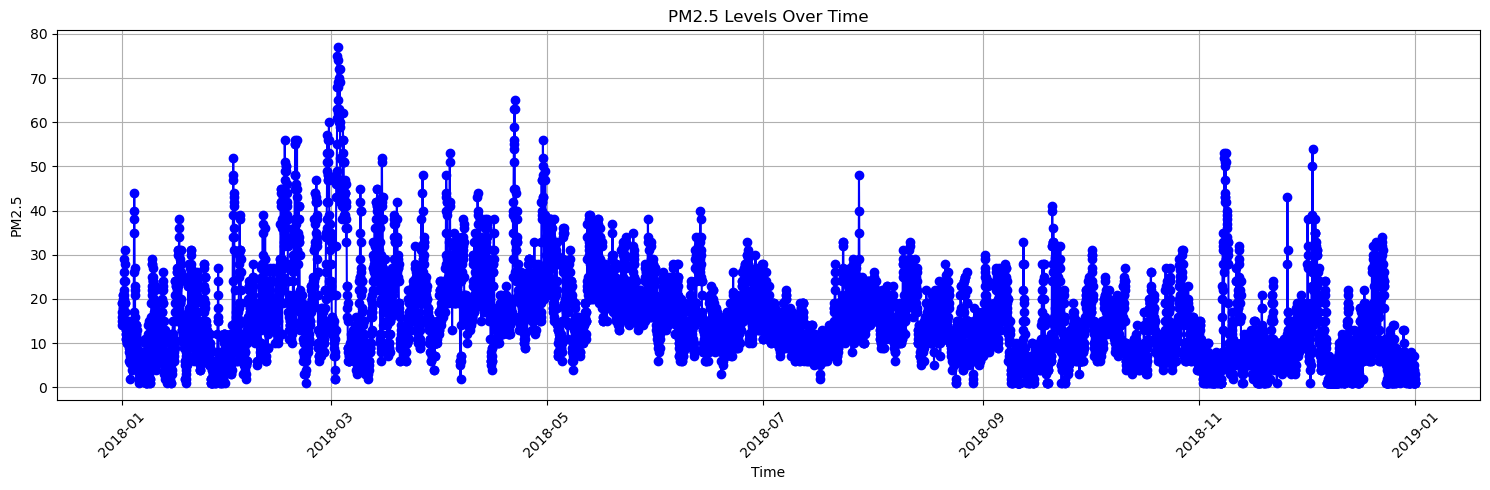

In [28]:
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(
    pm25_cailiao['readtime'], pm25_cailiao['pm25'], marker='o', linestyle='-', color='b'
    )
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()